In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

# Get the absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Add src_path to the system path
sys.path.insert(0, src_path)

from utils import mappings

SUBFIELDS_PERCENT_FILE_PATH = "../../data/processed/2_subfield_percentages.csv"
OUTPUT_FILE = "../../results/figures"

In [2]:
def plot_publication_percentages_four_countries(df):
    """
    Plots the publication percentages over the years for the top 5 subfields in 4 countries
    (BR, CN, US, IN) using a 2×2 grid of subplots with shared axes for proper comparison.

    For each country, the function:
      - Filters the data for the country.
      - Computes the total publications per year and calculates the percentage for each subfield.
      - Determines the top 5 subfields by total count.
      - Maps full subfield names to short versions.
      - Creates a line plot of the percentage over the years.
    
    A common legend (with alphabetically sorted labels) is added below the subplots.

    Parameters:
        df (pd.DataFrame): DataFrame containing publication data with columns:
                           'country_code', 'publication_year', 
                           'subfield_display_name', 'count'.

    Returns:
        matplotlib.figure.Figure: The figure object for the generated plot.
    """
    # Define the order of countries: BR, CN, US, IN
    countries = ["BR", "CN", "US", "IN"]
    sns.set_theme(style="whitegrid", context="paper", font_scale=2.2)

    # Create a 2×2 grid of subplots with shared x and y axes
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False, sharey=True)
    axes = axes.flatten()

    # Dictionary to collect legend entries across subplots
    legend_entries = {}

    for i, country in enumerate(countries):
        ax = axes[i]
        # Filter for the current country
        df_country = df[df["country_code"] == country].copy()

        # Compute total publications per year for this country
        total_per_year = (
            df_country.groupby("publication_year")["count"]
            .sum()
            .reset_index(name="total_count")
        )
        df_country = df_country.merge(total_per_year, on="publication_year", how="left")

        # Calculate the percentage of publications for each subfield per year
        df_country["percentage"] = (df_country["count"] / df_country["total_count"]) * 100

        # Determine the top 5 subfields by total count over all years for this country
        subfield_totals = (
            df_country.groupby("subfield_display_name")["count"]
            .sum()
            .reset_index()
        )
        top5 = subfield_totals.nlargest(5, "count")["subfield_display_name"].tolist()

        # Filter to include only the top 5 subfields
        df_top = df_country[df_country["subfield_display_name"].isin(top5)].copy()

        # Map full subfield names to short versions using .loc to avoid SettingWithCopyWarning
        df_top.loc[:, "subfield_short"] = df_top["subfield_display_name"].map(mappings.SUBFIELDS_SHORT)

        # Create the line plot using short subfield names for hue and style
        sns.lineplot(
            data=df_top,
            x="publication_year",
            y="percentage",
            hue="subfield_short",
            style="subfield_short",
            palette=mappings.COLOUR_PALETTE,
            markers=mappings.MARKERS,
            markersize=10,
            dashes=False,
            ax=ax,
            linewidth=2,
        )

        # Set grid, title, and axis labels
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.set_title(f"{mappings.COUNTRY_CODES.get(country, country)}", fontsize=20)
        ax.set_xlabel("Publication Year")
        ax.set_ylabel("Percentage (%)")

        # Collect legend handles and labels from the subplot
        handles, labels = ax.get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            legend_entries[label] = handle

        # Remove the individual legend from this subplot
        ax.get_legend().remove()

    # Create a common legend sorted alphabetically by label
    sorted_entries = sorted(legend_entries.items(), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_entries)
    fig.legend(
        sorted_handles,
        sorted_labels,
        loc="lower center",
        ncol=5,
        title="Subfields",
        frameon=True,
        bbox_to_anchor=(0.5, -0.02)
    )

    # Set overall title
    fig.suptitle("Subfields Distribitions in Four Contries (2015 -- 2024)")

    # Adjust layout to accommodate the common legend
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    
    # Save the figure to a PDF file
    plt.savefig(
        f"{OUTPUT_FILE}/publication_percentages_by_country.pdf",
        format="pdf",
        bbox_inches="tight",
    )

    return fig

In [3]:
# Load the CSV file with percentage data
df = pd.read_csv(SUBFIELDS_PERCENT_FILE_PATH)

In [4]:
df.head()

,publication_year,subfield_id,subfield_display_name,count,citation_count,country_code,total,percentage
0,2024,subfields/1707,Computer Vision and Pattern Recognition,483,239,BR,5167,9.347784
1,2024,subfields/1710,Information Systems,1932,399,BR,5167,37.391136
2,2024,subfields/1703,Computational Theory and Mathematics,282,250,BR,5167,5.457712
3,2024,subfields/1702,Artificial Intelligence,1186,709,BR,5167,22.953358
4,2024,subfields/1705,Computer Networks and Communications,550,345,BR,5167,10.644475


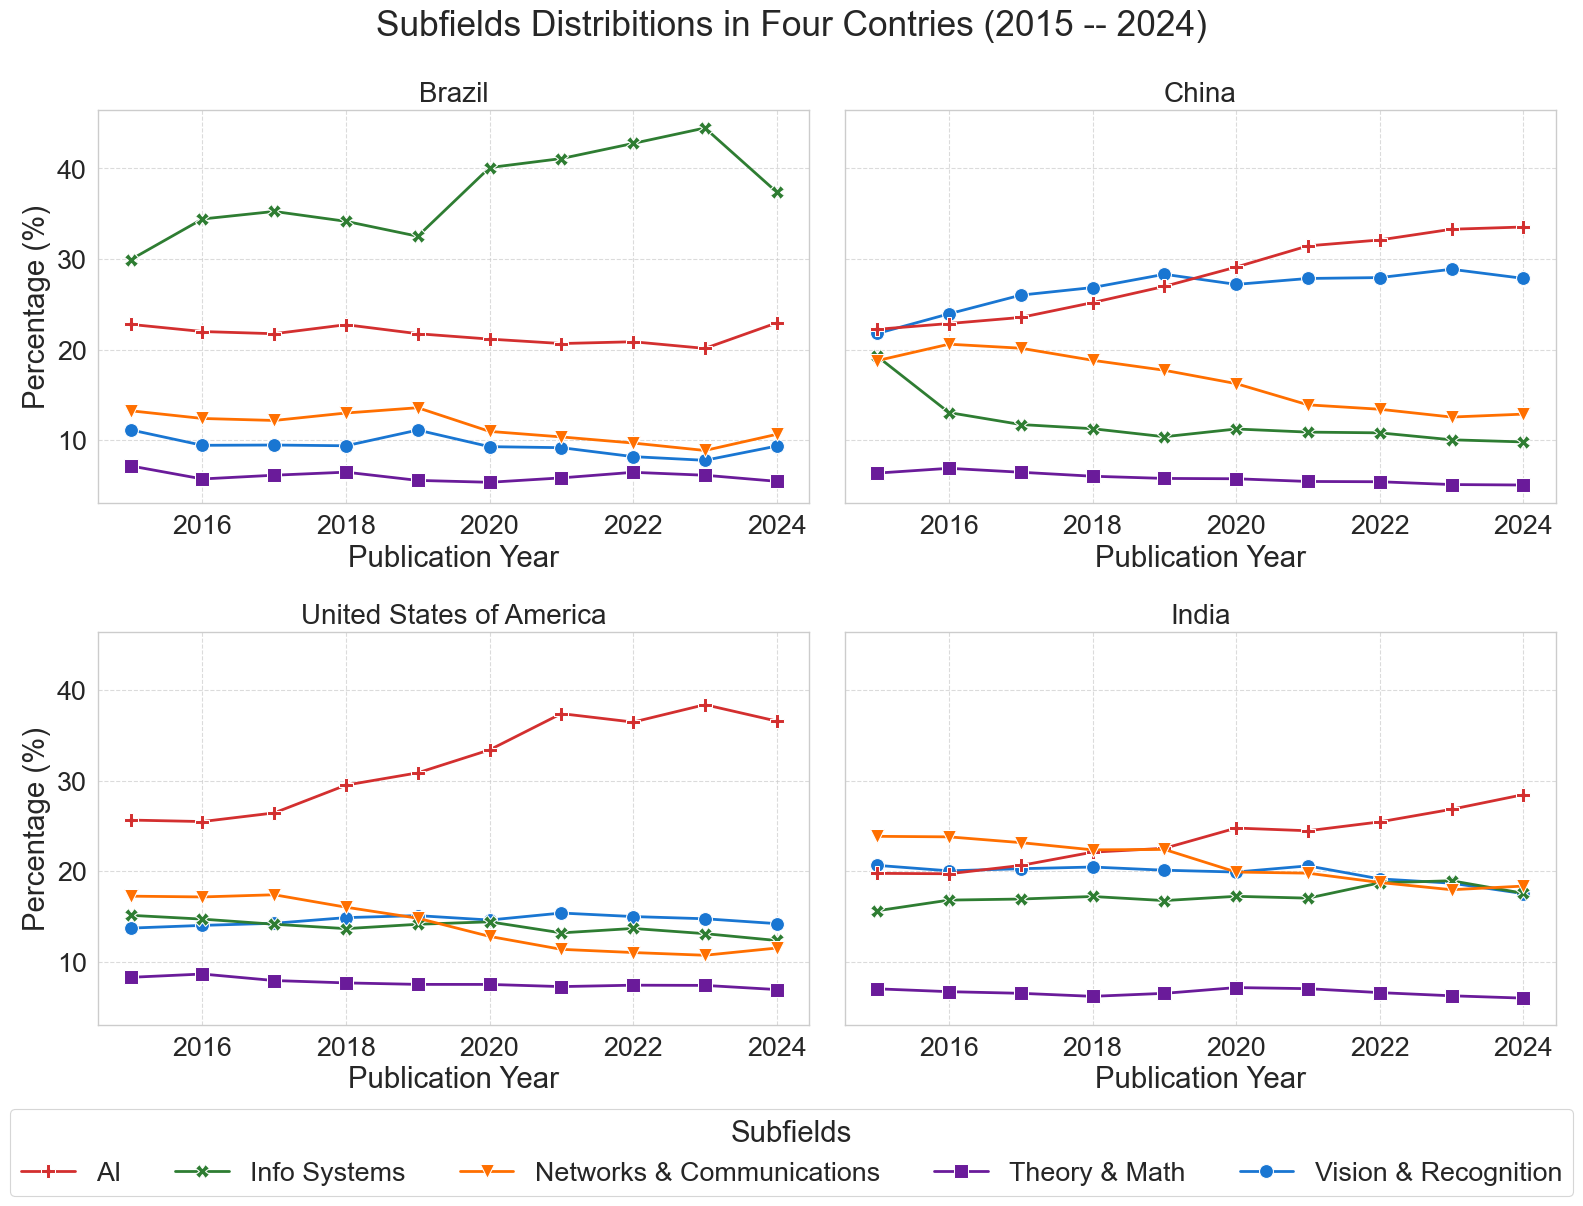

In [5]:
plot_publication_percentages_four_countries(df)
plt.show()